In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import json
%matplotlib inline


In [2]:

# na_filter = False -> None nao é um missing value
energia21 = pd.read_csv('./train_datasets/energia_202109-202112.csv', encoding='latin-1', na_filter=False)
energia22 = pd.read_csv('./train_datasets/energia_202201-202212.csv', encoding='latin-1',na_filter=False)

meteo21 = pd.read_csv('./train_datasets/meteo_202109-202112.csv', encoding='latin-1')
meteo22 = pd.read_csv('./train_datasets/meteo_202201-202212.csv', encoding='latin-1')

test_energia = pd.read_csv('./test_datasets/energia_202301-202304.csv', encoding='latin-1', na_filter=False)
test_meteo = pd.read_csv('./test_datasets/meteo_202301-202304.csv', encoding='latin-1', na_filter=False)


### Merge datasets

In [3]:
energiaDatasets = pd.concat([energia21, energia22])
energiaDatasets.to_csv("combinedEnergia.csv", index=False)

In [4]:
energiaDatasets.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,None
1,2021-09-29,1,0.0,0.0,0.0,None
2,2021-09-29,2,0.0,0.0,0.0,None
3,2021-09-29,3,0.0,0.0,0.0,None
4,2021-09-29,4,0.0,0.0,0.0,None


<Axes: >

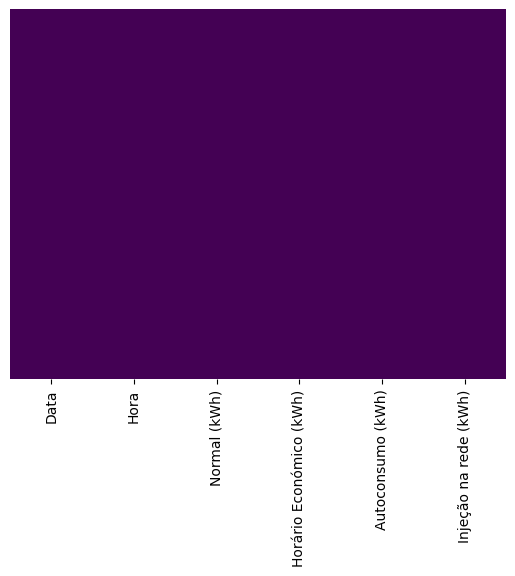

In [5]:
sns.heatmap(energiaDatasets.isnull(), yticklabels = False, cbar=False, cmap='viridis')

In [6]:
energiaDatasets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11016 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11016 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 602.4+ KB


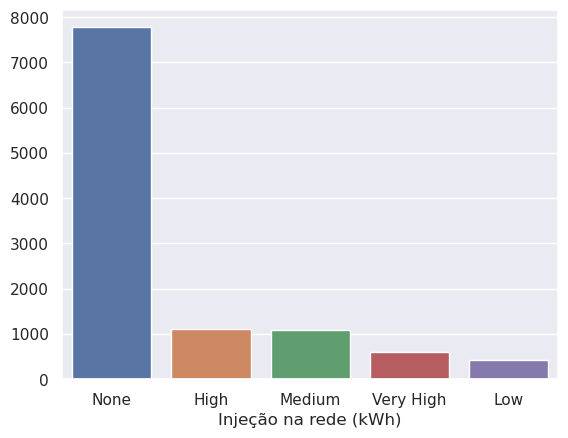

In [7]:
inj_count = energiaDatasets['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
sns.barplot(x=inj_count.index, y=inj_count.values)
plt.show()

In [8]:
'''
nova coluna para a injeção na rede ter valores
None-0, Low-1, Medium-2, High-3, Very High-4
'''
column_mapping = {
    'Injeção na rede (kWh)': {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
}
for column, mapping in column_mapping.items():
    energiaDatasets[column] = energiaDatasets[column].map(mapping)

energiaDatasets.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,0
1,2021-09-29,1,0.0,0.0,0.0,0
2,2021-09-29,2,0.0,0.0,0.0,0
3,2021-09-29,3,0.0,0.0,0.0,0
4,2021-09-29,4,0.0,0.0,0.0,0


### combine datasets de metereologia

In [9]:
# Merge the two dataframes
meteoDatasets = pd.concat([meteo21, meteo22])

meteoDatasets.to_csv("combinedMeteo.csv", index=False)

In [10]:
meteoDatasets.isnull().sum()

dt                         0
dt_iso                     0
city_name                  0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              11688
grnd_level             11688
humidity                   0
wind_speed                 0
rain_1h                 9253
clouds_all                 0
weather_description        0
dtype: int64

<Axes: >

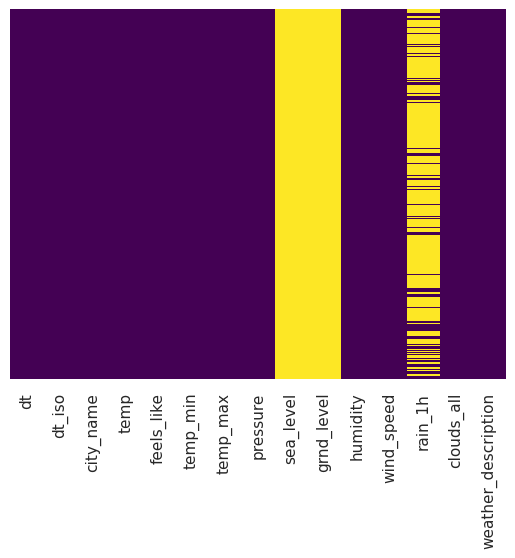

In [11]:
sns.heatmap(meteoDatasets.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
meteoDatasets.nunique()

dt                     11688
dt_iso                 11688
city_name                  1
temp                    2423
feels_like              2702
temp_min                 488
temp_max                 550
pressure                  41
sea_level                  0
grnd_level                 0
humidity                  82
wind_speed               771
rain_1h                  371
clouds_all               101
weather_description        8
dtype: int64

In [13]:
meteoDatasets.drop(['sea_level','grnd_level','city_name'], axis=1,inplace=True)

In [14]:
test_meteo.drop(['sea_level','grnd_level','city_name'], axis=1,inplace=True)

In [15]:
meteoDatasets['rain_1h'].describe()

count    2435.000000
mean        0.884760
std         1.073453
min         0.100000
25%         0.210000
50%         0.450000
75%         1.070000
max         7.450000
Name: rain_1h, dtype: float64

In [16]:
meteoDatasets['rain_1h'].skew()

2.456975261874293

In [17]:
test_meteo['rain_1h'] = test_meteo['rain_1h'].replace('', pd.NA)


In [18]:
test_meteo['rain_1h'] = test_meteo['rain_1h'].fillna(0.0)
meteoDatasets['rain_1h'] = meteoDatasets['rain_1h'].fillna(0.0)

# Converter a coluna de objeto para float
test_meteo['rain_1h'] = test_meteo['rain_1h'].astype(float)

### check standart deviation

In [19]:
#std = meteoDatasets.std().round(2).sort_values(ascending=False)
#std_test = test_meteo.std().round(2).sort_values(ascending=False)


In [20]:
meteoDatasets['weather_description'].unique()

array(['broken clouds', 'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'scattered clouds', 'sky is clear',
       'few clouds'], dtype=object)

In [21]:
column_mapping = {
    'weather_description': {'heavy intensity rain': 0, 'moderate rain':1, 'light rain':2, 'overcast clouds':3, 'scattered clouds':4, 'broken clouds':5, 'few clouds':6, 'sky is clear':7},
}
for column, mapping in column_mapping.items():
    meteoDatasets[column] = meteoDatasets[column].replace(mapping)
    test_meteo[column] = test_meteo[column].replace(mapping)

In [22]:
test_meteo['weather_description'].unique()

array([1, 0, 2, 3, 4, 6, 7, 5])

### Weather Description and clouds correlation


#### Light Rain

In [23]:
#filtered_df = meteoDatasets[(meteoDatasets['weather_description'] == 1) & (meteoDatasets['clouds_all'] < 20)]

# Printing clouds_all values of the filtered rows
#print(filtered_df['clouds_all'].values)

In [24]:
#correlation = meteoDatasets['weather_description'].corr(meteoDatasets['clouds_all'])

# Printing the correlation
#print(f"Correlation between 'weather_description' and 'clouds_all': {correlation}")

In [25]:
#meteoDatasets = meteoDatasets.drop(filtered_df.index)

In [26]:
test_meteo.head()

,dt,dt_iso,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1672531200,2023-01-01 00:00:00 +0000 UTC,12.93,12.76,12.72,13.43,1019,95,2.02,3.72,100,1
1,1672534800,2023-01-01 01:00:00 +0000 UTC,13.49,13.38,13.43,13.90,1018,95,2.18,3.26,100,1
2,1672538400,2023-01-01 02:00:00 +0000 UTC,13.55,13.44,13.48,14.82,1017,95,2.88,2.44,100,1
3,1672542000,2023-01-01 03:00:00 +0000 UTC,13.61,13.51,12.01,14.82,1016,95,3.63,1.74,100,1
4,1672545600,2023-01-01 04:00:00 +0000 UTC,13.59,13.49,12.01,14.82,1015,95,4.58,1.13,100,1


In [27]:
print(meteoDatasets['weather_description'].value_counts())

weather_description
7    3160
3    2591
2    1784
5    1528
4    1213
6     761
1     587
0      64
Name: count, dtype: int64


### New columns

In [28]:
meteoDatasets['dt_iso']

0       2021-09-01 00:00:00 +0000 UTC
1       2021-09-01 01:00:00 +0000 UTC
2       2021-09-01 02:00:00 +0000 UTC
3       2021-09-01 03:00:00 +0000 UTC
4       2021-09-01 04:00:00 +0000 UTC
                    ...              
8755    2022-12-31 19:00:00 +0000 UTC
8756    2022-12-31 20:00:00 +0000 UTC
8757    2022-12-31 21:00:00 +0000 UTC
8758    2022-12-31 22:00:00 +0000 UTC
8759    2022-12-31 23:00:00 +0000 UTC
Name: dt_iso, Length: 11688, dtype: object

In [29]:
meteoDatasets['dt_iso'] = meteoDatasets['dt_iso'].str.strip()
test_meteo['dt_iso'] =  test_meteo['dt_iso'].str.strip()

meteoDatasets['Data'] = meteoDatasets['dt_iso'].str.split().str[0]
test_meteo['Data'] = test_meteo['dt_iso'].str.split().str[0]

meteoDatasets['Hora'] = meteoDatasets['dt_iso'].str.split().str[1].str[:2].astype('int64')
test_meteo['Hora'] = test_meteo['dt_iso'].str.split().str[1].str[:2].astype('int64') # 2 primeiros digito


In [30]:
meteoDatasets['Data']

0       2021-09-01
1       2021-09-01
2       2021-09-01
3       2021-09-01
4       2021-09-01
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11688, dtype: object

In [31]:
energiaDatasets['Data']

0       2021-09-29
1       2021-09-29
2       2021-09-29
3       2021-09-29
4       2021-09-29
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11016, dtype: object

<Axes: >

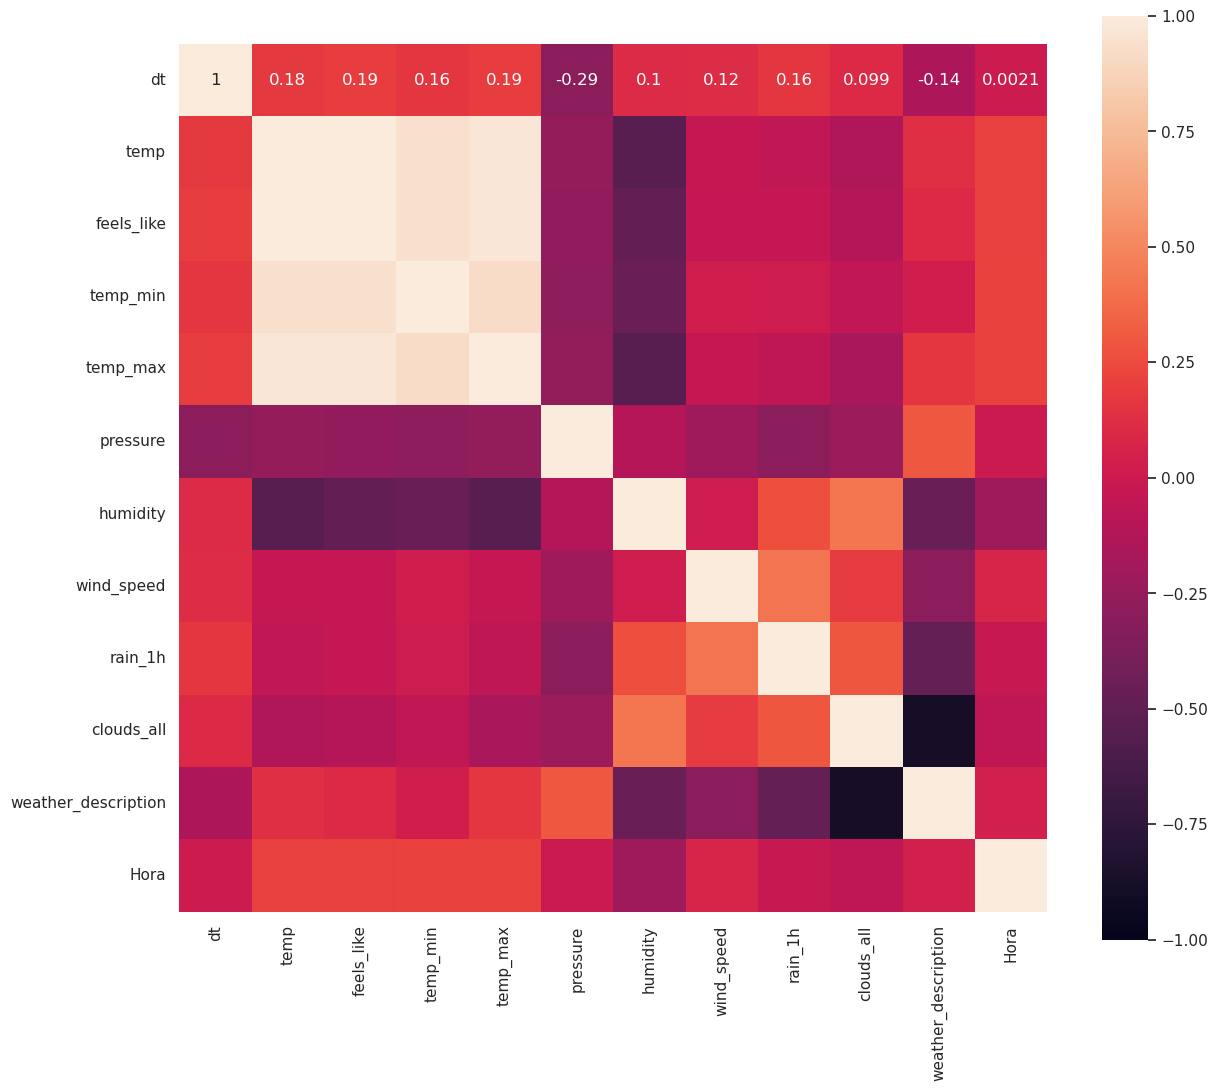

In [32]:
''''
Correlation meteoDatasets

'''
corr_matrix = meteoDatasets.drop(['dt_iso'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


**drop feature highly correlated**

In [33]:
meteoDatasets = meteoDatasets.drop(['temp_min', 'temp_max'], axis=1)
test_meteo = test_meteo.drop(['temp_min', 'temp_max'], axis=1)

## Merge train datasets

In [34]:
# meteoDatasets[['Data','Hora']].to_csv('data_hora_meteo.csv', index=False)

In [35]:
# energiaDatasets[['Data','Hora']].to_csv('data_hora_energia.csv', index=False)

In [36]:
energiaDatasets['Data']

0       2021-09-29
1       2021-09-29
2       2021-09-29
3       2021-09-29
4       2021-09-29
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11016, dtype: object

In [37]:
meteoDatasets['Data']

0       2021-09-01
1       2021-09-01
2       2021-09-01
3       2021-09-01
4       2021-09-01
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11688, dtype: object

In [38]:
merged_df = pd.merge(meteoDatasets, energiaDatasets , on=['Data', 'Hora'], how='inner') # inner join para nao haver missing values e começarem ambos na mesma data

In [39]:
merged_df['Data']

0        2021-09-29
1        2021-09-29
2        2021-09-29
3        2021-09-29
4        2021-09-29
            ...    
11011    2022-12-31
11012    2022-12-31
11013    2022-12-31
11014    2022-12-31
11015    2022-12-31
Name: Data, Length: 11016, dtype: object

<Axes: >

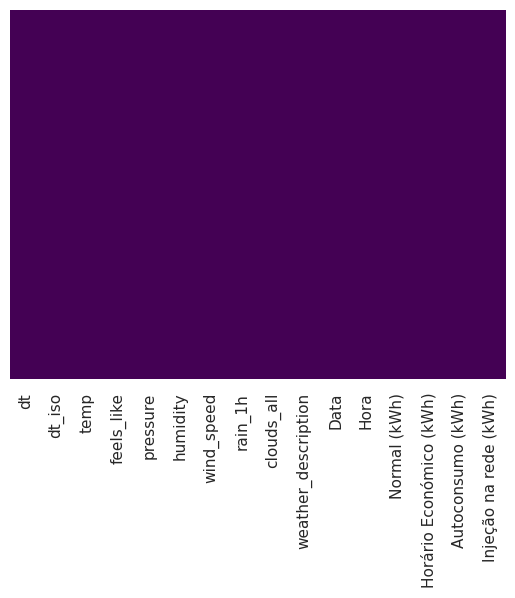

In [40]:
 sns.heatmap(merged_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

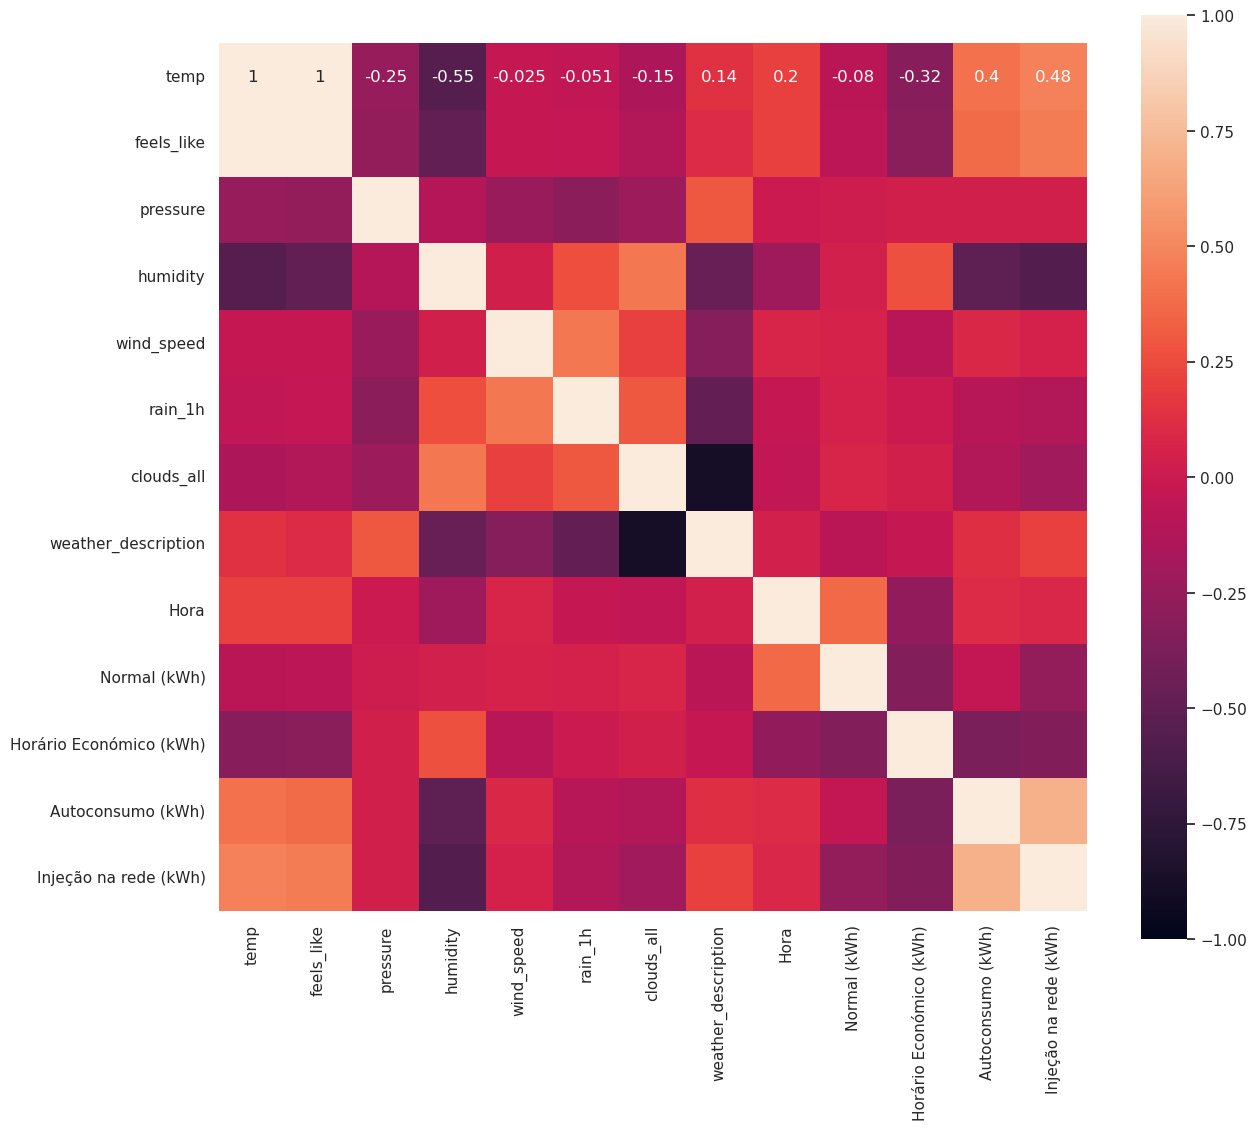

In [41]:
''''
Correlation

'''
corr_matrix = merged_df.drop(['Data', 'dt', 'dt_iso'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


In [42]:
'''columns_to_fill = ['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)']

for column in columns_to_fill:
    merged_df[column].fillna(merged_df[column].mean().round(4), inplace=True)

merged_df['Injeção na rede (kWh)'].fillna(merged_df["Injeção na rede (kWh)"].mode()[0], inplace=True)'''

'columns_to_fill = [\'Normal (kWh)\', \'Horário Económico (kWh)\', \'Autoconsumo (kWh)\']\n\nfor column in columns_to_fill:\n    merged_df[column].fillna(merged_df[column].mean().round(4), inplace=True)\n\nmerged_df[\'Injeção na rede (kWh)\'].fillna(merged_df["Injeção na rede (kWh)"].mode()[0], inplace=True)'

In [43]:
merged_df.to_csv('merged_df.csv', index=False)

nova coluna 'Mes'

In [44]:
merged_df['Mes'] = pd.DatetimeIndex(merged_df['Data']).month

## Merge test datasets

In [45]:
test_merged = pd.merge(test_meteo, test_energia , on=['Data', 'Hora'], how='outer')

test_merged.to_csv('test_merged.csv', index=False)
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dt                       1752 non-null   float64
 1   dt_iso                   1752 non-null   object 
 2   temp                     1752 non-null   float64
 3   feels_like               1752 non-null   float64
 4   pressure                 1752 non-null   float64
 5   humidity                 1752 non-null   float64
 6   wind_speed               1752 non-null   float64
 7   rain_1h                  1752 non-null   float64
 8   clouds_all               1752 non-null   float64
 9   weather_description      1752 non-null   float64
 10  Data                     2256 non-null   object 
 11  Hora                     2256 non-null   int64  
 12  Normal (kWh)             2256 non-null   float64
 13  Horário Económico (kWh)  2256 non-null   float64
 14  Autoconsumo (kWh)       

In [46]:
test_merged['Mes'] = pd.DatetimeIndex(test_merged['Data']).month

<Axes: >

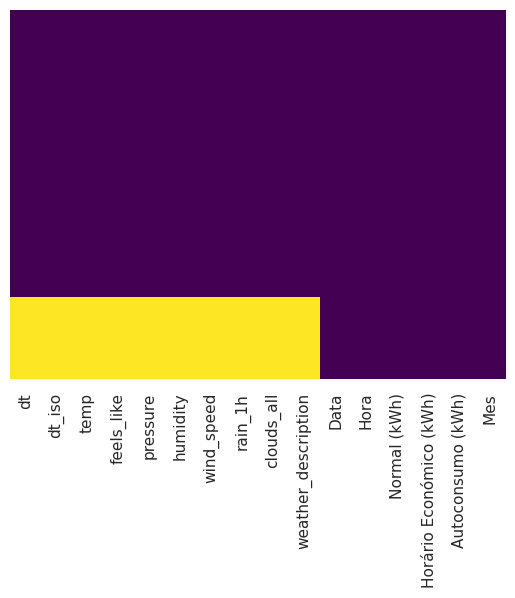

In [47]:
sns.heatmap(test_merged.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### substituir NaN no merge dos datasets de teste

In [48]:
'''columns_to_fillna = ['temp','temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h']
test_merged[columns_to_fillna] = test_merged[columns_to_fillna].fillna(test_merged[columns_to_fillna].mean())
columns_to_fillna = ['clouds_all', 'weather_description']

for column in columns_to_fillna:
    mode_value = test_merged[column].mode().iloc[0]  # Get the mode value
    test_merged[column] = test_merged[column].fillna(mode_value) '''

"columns_to_fillna = ['temp','temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h']\ntest_merged[columns_to_fillna] = test_merged[columns_to_fillna].fillna(test_merged[columns_to_fillna].mean())\ncolumns_to_fillna = ['clouds_all', 'weather_description']\n\nfor column in columns_to_fillna:\n    mode_value = test_merged[column].mode().iloc[0]  # Get the mode value\n    test_merged[column] = test_merged[column].fillna(mode_value) "

In [49]:
wb_df = pd.read_csv('./MissingDataWB.csv', encoding='latin-1',na_filter=False)


In [50]:
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   app_temp             504 non-null    float64
 1   azimuth              504 non-null    float64
 2   clouds               504 non-null    int64  
 3   datetime             504 non-null    object 
 4   dewpt                504 non-null    float64
 5   dhi                  504 non-null    int64  
 6   dni                  504 non-null    int64  
 7   elev_angle           504 non-null    float64
 8   ghi                  504 non-null    int64  
 9   h_angle              504 non-null    object 
 10  pod                  504 non-null    object 
 11  precip               504 non-null    float64
 12  pres                 504 non-null    int64  
 13  revision_status      504 non-null    object 
 14  rh                   504 non-null    int64  
 15  slp                  504 non-null    int

In [51]:
wb_df = wb_df[['datetime', 'temp', 'wind_spd', 'clouds', 'pres', 'rh', 'app_temp']]


wb_df[['Data', 'Hora']] = wb_df['datetime'].str.split(':', expand=True)

wb_df['Hora'] = wb_df['Hora'].astype(int)
wb_df = wb_df.drop('datetime',axis=1)

wb_df.rename(columns={"wind_spd": "wind_speed", "clouds": "clouds_all", "pres": "pressure","rh": "humidity", 'app_temp':'feels_like' }, inplace=True) # falta 'weather/description': 'weather_description'

In [52]:
#wb_df['weather_description'].unique()

In [53]:
'''column_mapping = {
    'weather_description': {'heavy intensity rain': 0, 'moderate rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few Clouds':6, 'Clear Sky':7},
}


for column, mapping in column_mapping.items():
    wb_df[column] = wb_df[column].replace(mapping)'''


"column_mapping = {\n    'weather_description': {'heavy intensity rain': 0, 'moderate rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few Clouds':6, 'Clear Sky':7},\n}\n\n\nfor column, mapping in column_mapping.items():\n    wb_df[column] = wb_df[column].replace(mapping)"

In [54]:
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        504 non-null    float64
 1   wind_speed  504 non-null    float64
 2   clouds_all  504 non-null    int64  
 3   pressure    504 non-null    int64  
 4   humidity    504 non-null    int64  
 5   feels_like  504 non-null    float64
 6   Data        504 non-null    object 
 7   Hora        504 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 31.6+ KB


In [55]:
test_merged['temp'].isnull().sum()

504

In [56]:
wb_df['temp']

0       7.4
1       7.0
2       6.7
3       5.9
4       5.9
       ... 
499    18.9
500    17.0
501    14.4
502    11.5
503    10.4
Name: temp, Length: 504, dtype: float64

In [57]:
columns_to_fillna = ['temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'feels_like']

if all(col in test_merged.columns and col in wb_df.columns for col in columns_to_fillna):
    # Preencha as últimas 504 linhas do DataFrame 'test_merged' com as linhas do DataFrame 'wb_df'
    for col in columns_to_fillna:
        test_merged.iloc[-504:, test_merged.columns.get_loc(col)] = wb_df[col].values


In [58]:
test_merged = test_merged.drop(['dt', 'dt_iso', 'weather_description', 'rain_1h'], axis=1)

In [59]:
test_merged.to_csv('new_test.csv', index=None)

<Axes: >

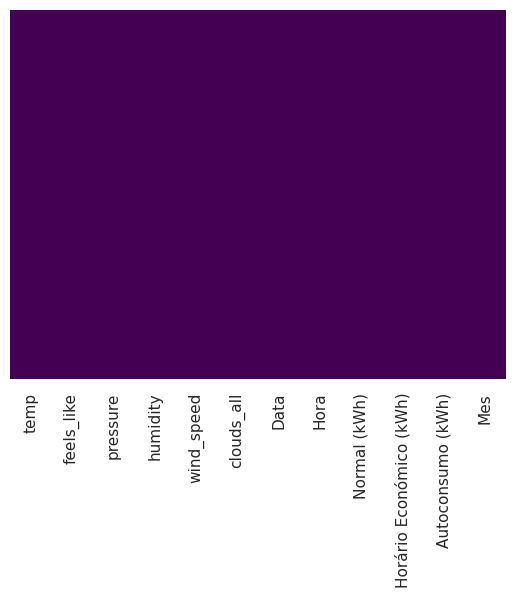

In [60]:
sns.heatmap(test_merged.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [61]:
merged_df=merged_df.drop(['dt_iso', 'weather_description', 'dt', 'rain_1h'],axis=1)
# merged_df=merged_df.drop(['dt_iso', 'dt'],axis=1)

adicionar novas colunas da API WeatherBit
elev_angle -> angulos dos paineis;
solar_rad -> radiação solar;
dni -> direct normal irradiance

In [62]:
new_data21 = pd.read_csv('./dadosWB21.csv', encoding='latin-1')
new_data22 = pd.read_csv('./dadosWB22.csv', encoding='latin-1')
new_data23 = pd.read_csv('./dadosWB23.csv', encoding='latin-1')

In [63]:
new_data21['datetime']

0       2021-09-29:00
1       2021-09-29:01
2       2021-09-29:02
3       2021-09-29:03
4       2021-09-29:04
            ...      
2251    2021-12-31:19
2252    2021-12-31:20
2253    2021-12-31:21
2254    2021-12-31:22
2255    2021-12-31:23
Name: datetime, Length: 2256, dtype: object

In [64]:
new_data22['datetime']

0       2022-01-01:00
1       2022-01-01:01
2       2022-01-01:02
3       2022-01-01:03
4       2022-01-01:04
            ...      
8755    2022-12-31:19
8756    2022-12-31:20
8757    2022-12-31:21
8758    2022-12-31:22
8759    2022-12-31:23
Name: datetime, Length: 8760, dtype: object

In [65]:
new_data21 = new_data21[['datetime', 'elev_angle']]
new_data22 = new_data22[['datetime', 'elev_angle']]
new_data23 = new_data23[['datetime', 'elev_angle']]

In [66]:
new_data2122 = pd.merge(new_data21, new_data22 , on=['datetime' , 'elev_angle'], how='outer')

In [67]:
new_data2122.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    11016 non-null  object 
 1   elev_angle  11016 non-null  float64
dtypes: float64(1), object(1)
memory usage: 172.2+ KB


In [68]:
new_data2122['datetime']

0        2021-09-29:00
1        2021-09-29:01
2        2021-09-29:02
3        2021-09-29:03
4        2021-09-29:04
             ...      
11011    2022-12-31:19
11012    2022-12-31:20
11013    2022-12-31:21
11014    2022-12-31:22
11015    2022-12-31:23
Name: datetime, Length: 11016, dtype: object

In [69]:
new_data2122.to_csv("2122.csv", index=False)

In [70]:
new_data2122[['Data', 'Hora']] = new_data2122['datetime'].str.split(':', expand=True)

new_data2122['Hora'] = new_data2122['Hora'].astype(int)
new_data2122 = new_data2122.drop('datetime',axis=1)

In [71]:
new_data23[['Data', 'Hora']] = new_data23['datetime'].str.split(':',  expand=True)
new_data23['Hora'] = new_data23['Hora'].astype(int)
new_data23 = new_data23.drop('datetime',axis=1)

In [72]:
new_data23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   elev_angle  2256 non-null   float64
 1   Data        2256 non-null   object 
 2   Hora        2256 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 53.0+ KB


In [73]:
new_data2122.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   elev_angle  11016 non-null  float64
 1   Data        11016 non-null  object 
 2   Hora        11016 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 258.3+ KB


In [74]:
# adicionar ao dataset de teste
test_merged = test_merged.merge(new_data23, on=['Data','Hora'], how='left')
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     2256 non-null   float64
 1   feels_like               2256 non-null   float64
 2   pressure                 2256 non-null   float64
 3   humidity                 2256 non-null   float64
 4   wind_speed               2256 non-null   float64
 5   clouds_all               2256 non-null   float64
 6   Data                     2256 non-null   object 
 7   Hora                     2256 non-null   int64  
 8   Normal (kWh)             2256 non-null   float64
 9   Horário Económico (kWh)  2256 non-null   float64
 10  Autoconsumo (kWh)        2256 non-null   float64
 11  Mes                      2256 non-null   int32  
 12  elev_angle               2256 non-null   float64
dtypes: float64(10), int32(1), int64(1), object(1)
memory usage: 220.4+ KB


In [75]:
# adicionar ao dataset de treino
merged_df = merged_df.merge(new_data2122, on=['Data','Hora'], how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     11016 non-null  float64
 1   feels_like               11016 non-null  float64
 2   pressure                 11016 non-null  int64  
 3   humidity                 11016 non-null  int64  
 4   wind_speed               11016 non-null  float64
 5   clouds_all               11016 non-null  int64  
 6   Data                     11016 non-null  object 
 7   Hora                     11016 non-null  int64  
 8   Normal (kWh)             11016 non-null  float64
 9   Horário Económico (kWh)  11016 non-null  float64
 10  Autoconsumo (kWh)        11016 non-null  float64
 11  Injeção na rede (kWh)    11016 non-null  int64  
 12  Mes                      11016 non-null  int32  
 13  elev_angle               11016 non-null  float64
dtypes: float64(7), int32(1

In [76]:
'''column_mapping = {
    'weather/description': {'Haze': 0, 'Heavy rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few clouds':6, 'Clear Sky':7, 'Thunderstorm with heavy rain':8, 'Moderate rain':9, 'Fog':10 , 'Thunderstorm with heavy rain':11},
}


for column, mapping in column_mapping.items():
    merged_df[column] = merged_df[column].replace(mapping)
    test_merged[column] = test_merged[column].replace(mapping)

    merged_df['weather/description'].astype(int)
    '''

"column_mapping = {\n    'weather/description': {'Haze': 0, 'Heavy rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few clouds':6, 'Clear Sky':7, 'Thunderstorm with heavy rain':8, 'Moderate rain':9, 'Fog':10 , 'Thunderstorm with heavy rain':11},\n}\n\n\nfor column, mapping in column_mapping.items():\n    merged_df[column] = merged_df[column].replace(mapping)\n    test_merged[column] = test_merged[column].replace(mapping)\n\n    merged_df['weather/description'].astype(int)\n    "

<Axes: >

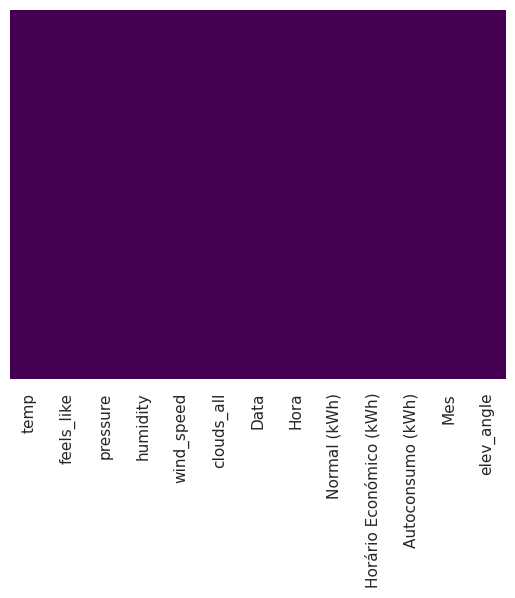

In [77]:
sns.heatmap(test_merged.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

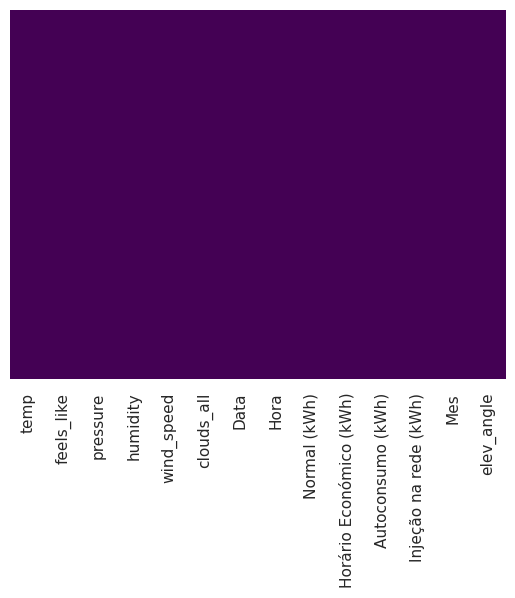

In [78]:
sns.heatmap(merged_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Outliers

<Axes: ylabel='wind_speed'>

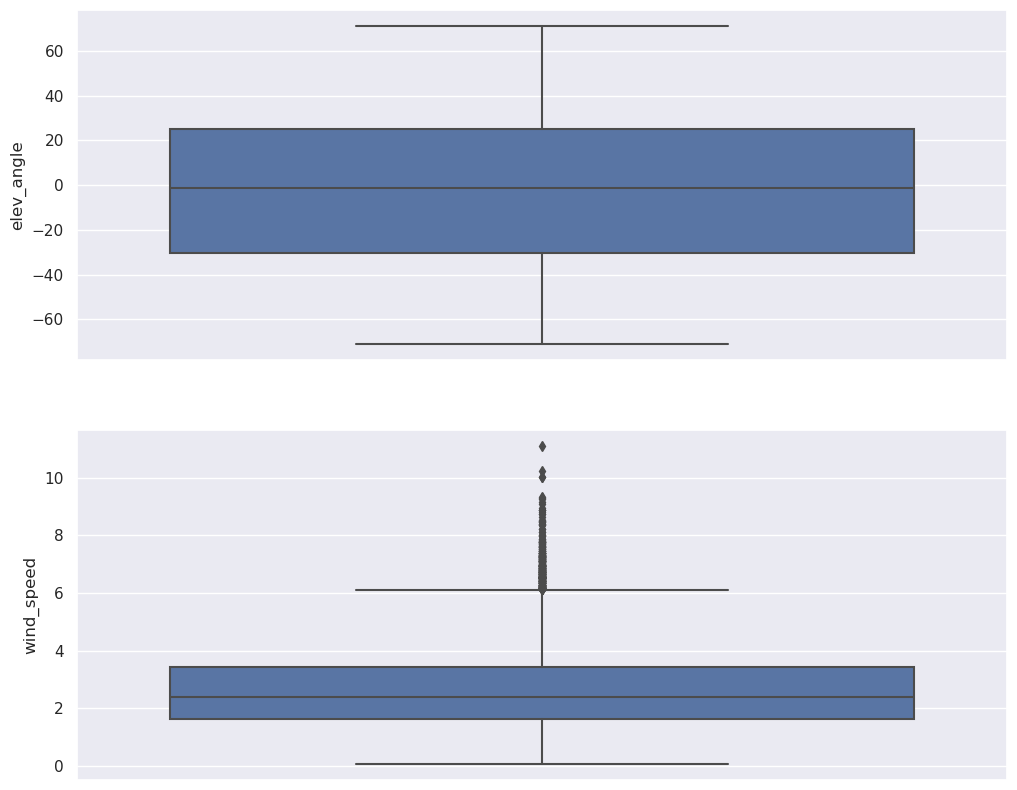

In [79]:
fig, axs = plt.subplots(2,1,figsize=(12,10))
sns.boxplot(y=merged_df['elev_angle'], ax=axs[0])
sns.boxplot(y=merged_df['wind_speed'], ax=axs[1])

/home/francisca/miniconda3/envs/daa/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/francisca/miniconda3/envs/daa/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


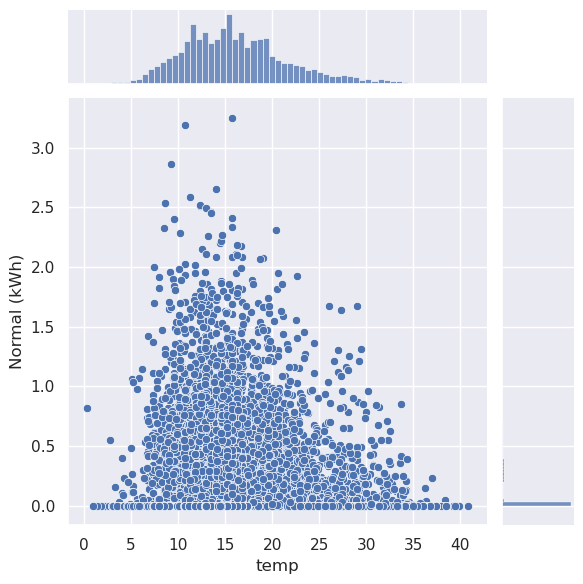

In [80]:
sns.jointplot(merged_df, x='temp', y='Normal (kWh)')

### Explore the dataset

In [81]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     11016 non-null  float64
 1   feels_like               11016 non-null  float64
 2   pressure                 11016 non-null  int64  
 3   humidity                 11016 non-null  int64  
 4   wind_speed               11016 non-null  float64
 5   clouds_all               11016 non-null  int64  
 6   Data                     11016 non-null  object 
 7   Hora                     11016 non-null  int64  
 8   Normal (kWh)             11016 non-null  float64
 9   Horário Económico (kWh)  11016 non-null  float64
 10  Autoconsumo (kWh)        11016 non-null  float64
 11  Injeção na rede (kWh)    11016 non-null  int64  
 12  Mes                      11016 non-null  int32  
 13  elev_angle               11016 non-null  float64
dtypes: float64(7), int32(1

<Axes: >

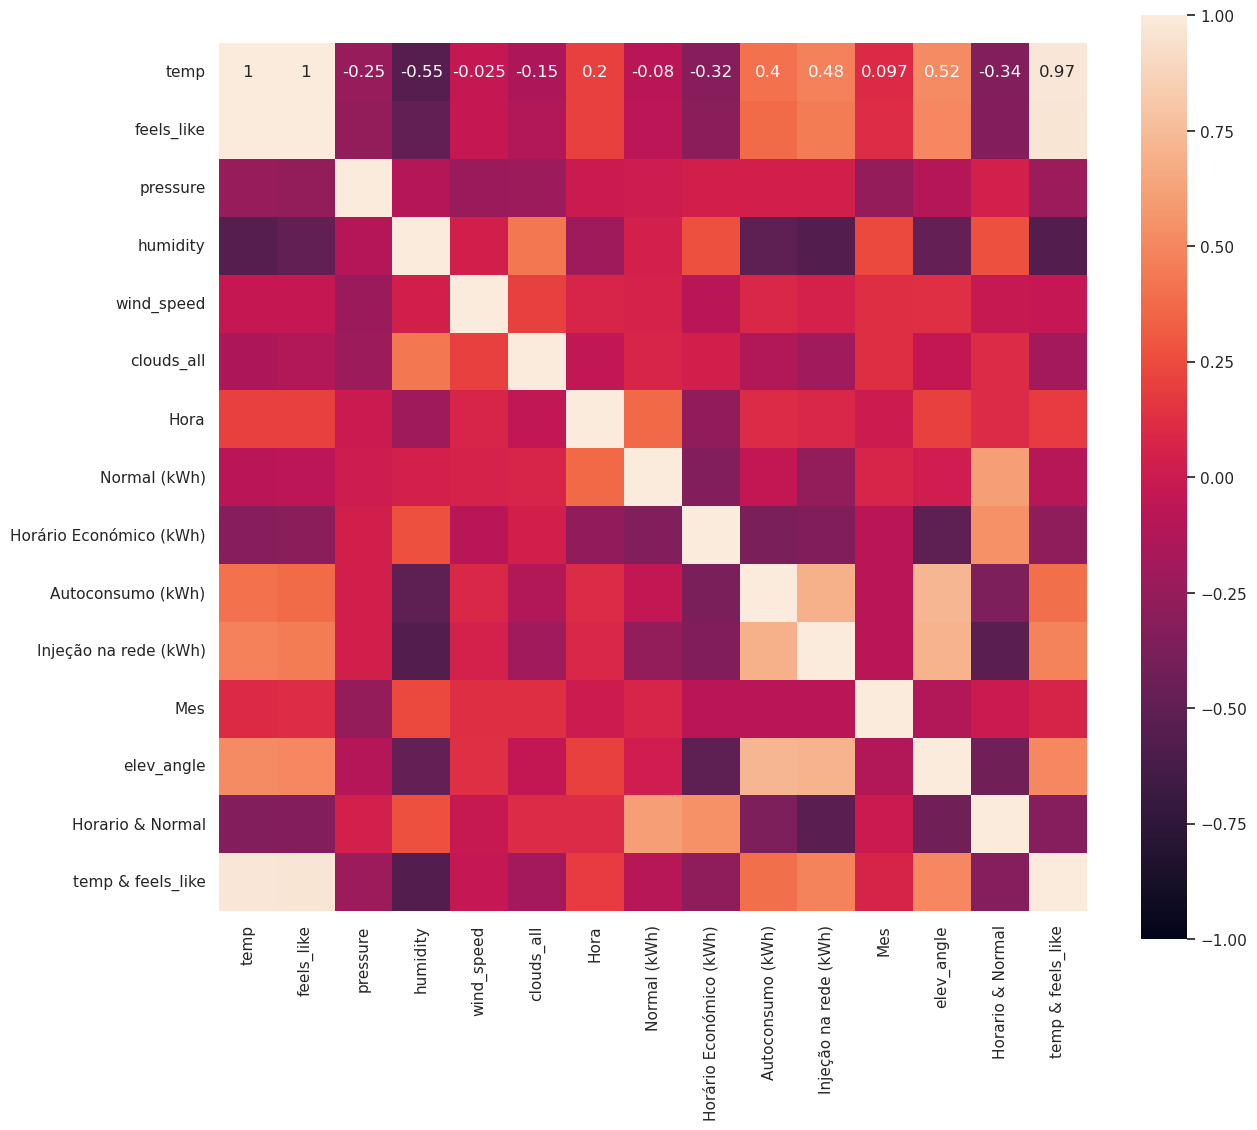

In [82]:
''''
Correlation

'''
merged_df['Horario & Normal'] = merged_df['Horário Económico (kWh)']*0.55 + merged_df['Normal (kWh)']*0.45
merged_df['temp & feels_like'] = merged_df['temp'] * merged_df['feels_like']
test_merged['Horario & Normal'] = test_merged['Horário Económico (kWh)']*0.55 + test_merged['Normal (kWh)']*0.45
test_merged['temp & feels_like'] = test_merged['temp'] * test_merged['feels_like']
corr_matrix = merged_df.drop(['Data'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


In [83]:
# drop 'AutoConsumo'
#merged_df = merged_df.drop(['Autoconsumo (kWh)'], axis=1)
#test_merged = test_merged.drop(['Autoconsumo (kWh)'], axis=1)

nova coluna 'tempHum':
Esta nova coluna irá relacionar a temperatura em graus com a % de humidade sentida nesse dia

In [84]:
'''merged_df['tempHum'] =  round(merged_df['temp'] - (merged_df['temp'] * (merged_df['humidity'] / 100.0)), 2)'''

"merged_df['tempHum'] =  round(merged_df['temp'] - (merged_df['temp'] * (merged_df['humidity'] / 100.0)), 2)"

In [85]:
'''test_merged['tempHum'] =  round(test_merged['temp'] - (test_merged['temp'] * (test_merged['humidity'] / 100.0)), 2)'''

"test_merged['tempHum'] =  round(test_merged['temp'] - (test_merged['temp'] * (test_merged['humidity'] / 100.0)), 2)"

voltar a passar os dados para categoricos

In [86]:
'''column_mapping = {
    'Injeção na rede (kWh)': {0: 'None', 1:'Low',2: 'Medium', 3: 'High', 4:'Very High'},
}
for column, mapping in column_mapping.items():
    merged_df[column] = merged_df[column].map(mapping)

merged_df.head()'''

"column_mapping = {\n    'Injeção na rede (kWh)': {0: 'None', 1:'Low',2: 'Medium', 3: 'High', 4:'Very High'},\n}\nfor column, mapping in column_mapping.items():\n    merged_df[column] = merged_df[column].map(mapping)\n\nmerged_df.head()"

## Algoritmos

In [87]:
df = merged_df.copy()

### Support Vector Machine

In [88]:
'''df_svm=pd.DataFrame(data=merged_df)
df_svm.head()'''

'df_svm=pd.DataFrame(data=merged_df)\ndf_svm.head()'

In [89]:
#df_svm = df_svm.drop(['dt','dt_iso', 'Data'],  axis=1)

In [90]:
'''
scale variables in 0 to 1 because SVM is sensitive to scale

df_svm = (df_svm - df_svm.min()) / (df_svm.max() - df_svm.min())
df_svm.head()
'''


'\nscale variables in 0 to 1 because SVM is sensitive to scale\n\ndf_svm = (df_svm - df_svm.min()) / (df_svm.max() - df_svm.min())\ndf_svm.head()\n'

In [91]:
'''X_train = df_svm.drop(['Injeção na rede (kWh)', 'wind_speed','Hora','pressure'], axis=1)
X_test = test_merged.drop(['Data', 'wind_speed','Hora','pressure'], axis=1)
y_train = df_svm['Injeção na rede (kWh)']'''

"X_train = df_svm.drop(['Injeção na rede (kWh)', 'wind_speed','Hora','pressure'], axis=1)\nX_test = test_merged.drop(['Data', 'wind_speed','Hora','pressure'], axis=1)\ny_train = df_svm['Injeção na rede (kWh)']"

In [92]:
#scale
'''from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)
'''

'from sklearn.preprocessing import MinMaxScaler\n\nminmax_scaler = MinMaxScaler()\nX_train_minmax = minmax_scaler.fit_transform(X_train)\nX_test_minmax = minmax_scaler.transform(X_test)\n'

In [93]:
'''from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#h1=svm.LinearSVC(C=1) # c=1 hyperparameters without gridsearch
param_grid = {'C': [0.1,1,10,100,1000], 'gamma':[1,0.1,0.01, 0.001, 0.0001], 'kernel':['rbf']}'''

"from sklearn.svm import SVC\nfrom sklearn.model_selection import GridSearchCV\n\n#h1=svm.LinearSVC(C=1) # c=1 hyperparameters without gridsearch\nparam_grid = {'C': [0.1,1,10,100,1000], 'gamma':[1,0.1,0.01, 0.001, 0.0001], 'kernel':['rbf']}"

In [94]:
#grid = GridSearchCV(SVC(random_state=2021), param_grid, refit=True, verbose=3)''

In [95]:
'''label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)'''

'label_encoder = LabelEncoder()\ny_train_encoded = label_encoder.fit_transform(y_train)'

In [96]:
#grid.fit(X_train_minmax,y_train)

In [97]:
#grid.best_params_

In [98]:
#predictions=grid.predict(X_test_minmax)

### Random Forest

In [99]:
random_forest = merged_df.copy()

In [100]:
X_train = random_forest.drop(['Injeção na rede (kWh)','Data'], axis=1)
X_test = test_merged.drop(['Data'], axis=1)
y_train = random_forest['Injeção na rede (kWh)'].astype(int)

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2,5,8],
    'n_estimators': [10, 30, 50, 70],
    'max_depth': [1,2,3,5]
}
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [102]:
#best_rf = grid_search.best_estimator_

In [103]:

'''feature_importances = best_rf.feature_importances_
train_predictions = best_rf.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_predictions = best_rf.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)'''

'feature_importances = best_rf.feature_importances_\ntrain_predictions = best_rf.predict(X_train)\ntrain_accuracy = metrics.accuracy_score(y_train, train_predictions)\ntest_predictions = best_rf.predict(X_test)\ntest_accuracy = metrics.accuracy_score(y_test, test_predictions)'

In [104]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=

[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=70; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_sam

/home/francisca/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1728 fits failed out of a total of 3456.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1095 fits failed with the following error:
Traceback (most recent call last):
  File "/home/francisca/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/francisca/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/francisca/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [10, 30, 50, 70]},
             verbose=2)

In [105]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 10}

In [106]:
predictions=grid_search.predict(X_test)

### Ensemble Learning - boosting

In [107]:
'''X_train = df.drop(['Injeção na rede (kWh)','Data','temp','feels_like'], axis=1)
X_test = test_merged.drop(['Data', 'temp', 'feels_like'], axis=1)
y_train = df['Injeção na rede (kWh)'].astype(int)'''

"X_train = df.drop(['Injeção na rede (kWh)','Data','temp','feels_like'], axis=1)\nX_test = test_merged.drop(['Data', 'temp', 'feels_like'], axis=1)\ny_train = df['Injeção na rede (kWh)'].astype(int)"

In [108]:
'''from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)'''

'from sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nparameters = {\n    "loss":["deviance"],\n    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],\n    "min_samples_split": np.linspace(0.1, 0.5, 12),\n    "min_samples_leaf": np.linspace(0.1, 0.5, 12),\n    "max_depth":[3,5,8],\n    "max_features":["log2","sqrt"],\n    "criterion": ["friedman_mse",  "mae"],\n    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],\n    "n_estimators":[10]\n    }\n\nclf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)'

In [109]:
#clf.fit(X_train, y_train)

In [110]:
#print(clf.score(X_train, y_train))

In [111]:
#print(clf.best_params_)

In [112]:
# Predict on test set
#predictions = clf.predict(X_test)

### XdgBoosting

In [113]:
'''from xgboost import XGBClassifier
#xgb = XGBClassifier(max_depth=1, objective='reg:squarederror')
xgb = XGBClassifier(learning_rate=0.02, n_estimators=200, objective='multi:softmax',num_class=5,
                    silent=True)'''

"from xgboost import XGBClassifier\n#xgb = XGBClassifier(max_depth=1, objective='reg:squarederror')\nxgb = XGBClassifier(learning_rate=0.02, n_estimators=200, objective='multi:softmax',num_class=5,\n                    silent=True)"

In [114]:
'''params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1,3,5]
        }'''

"params = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0.5, 1, 1.5, 5],\n        'subsample': [0.6, 0.8, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [1,3,5]\n        }"

In [115]:
'''from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', verbose=3, refit=True )'''

"from sklearn.model_selection import GridSearchCV\ngrid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', verbose=3, refit=True )"

In [116]:
#grid.fit(X_train,y_train)

In [117]:
#grid.best_params_

In [118]:
#predictions = grid.predict(X_test)

In [119]:
mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
mapped_predictions = np.vectorize(mapping.get)(predictions)
mapped_predictions = np.array(mapped_predictions)

In [120]:
predicted_labels = [mapping[prediction] for prediction in predictions]

## SUBMISSAO

In [121]:
test_merged['RowId'] = test_merged.index + 1

In [122]:
submission = pd.DataFrame({
    'RowId': test_merged['RowId'],
    'Result': predicted_labels
})


In [123]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   RowId   2256 non-null   int64 
 1   Result  2256 non-null   object
dtypes: int64(1), object(1)
memory usage: 35.4+ KB


In [124]:
submission.to_csv('submission.csv', index=None)

In [125]:
df.to_csv('bruh.csv', index=None)